In [1]:
import itertools

import numpy as np
from qualtran import QUInt
from qualtran.bloqs.mod_arithmetic import CModMulK
from qualtran.surface_code import (
    AlgorithmSummary,
    CompactDataBlock,
    FastDataBlock,
    PhysicalCostModel,
    PhysicalParameters,
    QECScheme,
    SimpleDataBlock,
)


**Step 1**: Define key size

In [2]:
key_size = 2048

**Step 2.** Create the Bloq which defines the subcircuit dominating the resource cost of the algorithm. In this case (and most cases) it is the controlled modular multiplier.

- `modulus` is the integer to be factored. Since the resource cost is (usually) the same for any $n$-bit integer, for simplicity we take it to be $N = 2^n - 1$.
- `multiplicand` is the classically pre-computed constant which is multiplied by the value in the quantum register, i.e., the number $a$ in the quantum computation $\ket{x} \mapsto \ket{ax \mod N}$.<br>The resource cost of the controlled modular multiplier is also (usually) invariant in the value of $a$. Since $a$ must be coprime to $N$, for simplicity we take it to be $a = N - 1 = 2^n - 2$.

In [3]:
modulus = 2**key_size - 1
multiplicand = 2**key_size - 2

mod_mul = CModMulK(dtype=QUInt(key_size), k=multiplicand, mod=modulus)

**Step 3.** Compute the number of times the subcircuit is repeated in the entire algorithm. To again match the implementation of [Gidney and Ekerå](https://doi.org/10.22331/q-2021-04-15-433), we take this to be $1.5 n$.

In [4]:
subcircuit_reps = int(1.5 * key_size)

**Step 4.** Convert logical resource estimates from the circuit defined by Qualtran Bloqs into a format that can be input to Microsoft's Azure Quantum Resource Estimator.

*Note: this steps takes a while! (About 1 min)*

In [5]:
alg_controlled_mod_mul = AlgorithmSummary.from_bloq(mod_mul)
alg_controlled_mod_mul

KeyboardInterrupt: 

**Step 5**: Retrieve logical estimates for mod exp from controlled mod mul

In [34]:
alg_mod_exp = AlgorithmSummary(
    n_algo_qubits=alg_controlled_mod_mul.n_algo_qubits,
    n_logical_gates=alg_controlled_mod_mul.n_logical_gates * subcircuit_reps,
)
alg_mod_exp

AlgorithmSummary(n_algo_qubits=6143, n_logical_gates=GateCounts(t=0, toffoli=0, cswap=6291456, and_bloq=128786104320, clifford=1030163005440, rotation=0, measurement=128786104320), n_rotation_layers=None)

### **OPTION 1**: Physical resource estimates w/ Qualtran

**Step 6a**: Create cost model. In qualtran we currently have a choice between the gidney-fowler model, adn the beverland et al model. These can be further customized as per requirements

In [42]:
# For minimal configuration, you can use a set of defaults from
# the literature. Here: Gidney and Fowler (2018).

cost_model = PhysicalCostModel.make_gidney_fowler(data_d=27)
cost_model

PhysicalCostModel(physical_params=PhysicalParameters(physical_error=0.001, cycle_time_us=1.0), data_block=SimpleDataBlock(data_d=27, routing_overhead=0.5), factory=CCZ2TFactory(distillation_l1_d=15, distillation_l2_d=31), qec_scheme=QECScheme(error_rate_scaler=0.1, error_rate_threshold=0.01))

**Step 6b:** test resource estimation for a single controlled-mod mul usign a *distance* 25 code with the gidney fowler model.

In [47]:
print(
    f"Duration {cost_model.duration_hr(alg_controlled_mod_mul):.2f} hr",
    f"\nPhysical Qubits {cost_model.n_phys_qubits(alg_controlled_mod_mul):,d}",
    f"\nError {cost_model.error(alg_controlled_mod_mul):.2g}",
)

Duration 1.99 hr 
Physical Qubits 13,583,374 
Error 0.068


**Step 6c**: Resource estiamte for mod exp in gidney fowler model

In [48]:
print(
    f"Duration {cost_model.duration_hr(alg_mod_exp):.2f} hr",
    f"\nPhysical Qubits {cost_model.n_phys_qubits(alg_mod_exp):,d}",
    f"\nError {cost_model.error(alg_mod_exp):.2g}",
)

Duration 6099.75 hr 
Physical Qubits 13,583,374 
Error 2.1e+02


*Note:* As we can see from above, the error is really bad. We potentially a larger distance code or a differernt distillation method. We haven't fully incorporated all of Gidney's techniques yet, so , this cost is bound to go down

**Step 7**: function testing many possible combinations of cost models to compute physical resource estimates. We vary the 

- datablock type (i.e. the layout of logical qubits on teh surface code), 
- the factory type (CCZ vs T), 
- the QEC scheme (this takes into account some assumtiposmn abotu the logical noise scaling etc.), and finally 
- some more concrete params about the physical err rate etc.

In [51]:
from qualtran.surface_code import CCZ2TFactory, FifteenToOne

data_d = 27

data_blocks = [
    SimpleDataBlock(data_d=data_d),
    CompactDataBlock(data_d=data_d),
    FastDataBlock(data_d=data_d),
]

factories = [
    CCZ2TFactory(),
    FifteenToOne(data_d, data_d, data_d),
]

schemes = [
    QECScheme.make_gidney_fowler(),
    QECScheme.make_beverland_et_al(),
]

phys_params = [
    PhysicalParameters.make_beverland_et_al(),
    PhysicalParameters.make_beverland_et_al(optimistic_err_rate=True),
    PhysicalParameters.make_gidney_fowler(),
    PhysicalParameters.make_gidney_fowler(optimistic_err_rate=True),
]

In [54]:
def compute_physical_estimates(alg, data_block, factory, scheme, phys):
    """Estimate the runtime and physical qubits required for the algorithm."""
    model = PhysicalCostModel(
        data_block=data_block, factory=factory, qec_scheme=scheme, physical_params=phys
    )
    duration_hr_estimate = model.duration_hr(alg)
    n_physical_qubits_estimate = model.n_phys_qubits(alg)

    return {
        "duration_hr_estimate": duration_hr_estimate,
        "n_physical_qubits_estimate": n_physical_qubits_estimate,
    }

In [57]:
duration_hr_estimates = []
n_physical_qubits_estimates = []
for data_block, factory, scheme, phys in itertools.product(
    data_blocks, factories, schemes, phys_params
):
    costs = compute_physical_estimates(
        alg=alg_mod_exp, data_block=data_block, factory=factory, scheme=scheme, phys=phys
    )

    duration_hr_estimates.append(costs["duration_hr_estimate"])
    n_physical_qubits_estimates.append(costs["n_physical_qubits_estimate"])

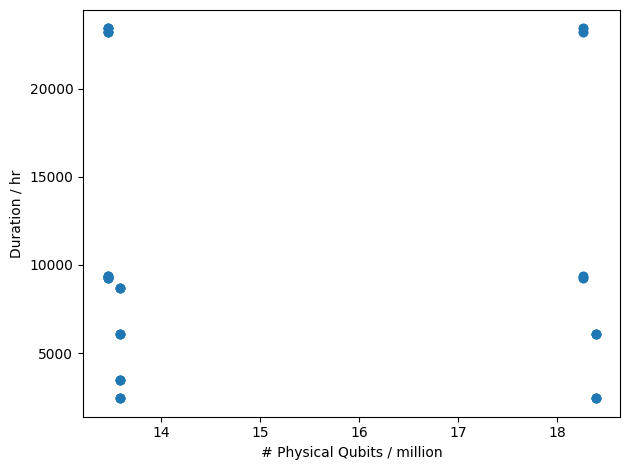

In [58]:
from matplotlib import pyplot as plt

plt.scatter(np.array(n_physical_qubits_estimates) / 1e6, duration_hr_estimates)
plt.xlabel("# Physical Qubits / million")
plt.ylabel("Duration / hr")
plt.tight_layout()

#### **Option 2**: Using a combination of Qualtran and Microsoft QRE